# Gemstones Classification

This dataset contains 3,200+ images of different gemstones. The images are grouped into 87 classes which are already divided into train and test data. All images are in various sizes and are in .jpeg format.
As for gemstones I tried to include them in various shapes - round, oval, square, rectangle, heart.

This dataset is composed of two folders:

train (56 MB): This file contains 87 subfolders and ~2,800 files in total. Each subfolder contains .jpeg images of different gemstones.

test (8 MB): This file contains 87 subfolders and ~400 files in total. Each subfolder contains .jpeg images of different gemstones.

In [1]:
import opendatasets as od
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
od.download('https://www.kaggle.com/lsind18/gemstones-images')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dikshantkalotra
Your Kaggle Key: ········


  0%|                                                                                      | 0.00/55.2M [00:00<?, ?B/s]

100%|█████████████████████████████████████████████████████████████████████████████| 55.2M/55.2M [00:09<00:00, 5.99MB/s]


# Preparing the Gemstone Dataset

In [2]:
data_dir = './gemstones-images'

In [3]:
print(os.listdir(data_dir))
print(os.listdir(data_dir + '/train'))

['train', 'test']
['Beryl Golden', 'Hessonite', 'Carnelian', 'Onyx Black', 'Spinel', 'Labradorite', 'Aquamarine', 'Serpentine', 'Amber', 'Tsavorite', 'Lapis Lazuli', 'Sapphire Pink', 'Scapolite', 'Prehnite', 'Tourmaline', 'Morganite', 'Aventurine Green', 'Goshenite', 'Sapphire Blue', 'Citrine', 'Jade', 'Onyx Red', 'Larimar', 'Cats Eye', 'Ametrine', 'Rhodonite', 'Amazonite', 'Andalusite', 'Coral', 'Aventurine Yellow', 'Sodalite', 'Tanzanite', 'Almandine', 'Pyrope', 'Dumortierite', 'Danburite', 'Emerald', 'Peridot', 'Hiddenite', 'Benitoite', 'Alexandrite', 'Spodumene', 'Chrome Diopside', 'Moonstone', 'Garnet Red', 'Chrysoberyl', 'Andradite', 'Amethyst', 'Fluorite', 'Turquoise', 'Kunzite', 'Sapphire Yellow', 'Blue Lace Agate', 'Topaz', 'Quartz Beer', 'Quartz Rose', 'Diaspore', 'Sapphire Purple', 'Pearl', 'Zoisite', 'Chalcedony Blue', 'Quartz Lemon', 'Onyx Green', 'Rhodochrosite', 'Jasper', 'Zircon', 'Kyanite', 'Malachite', 'Spessartite', 'Sphene', 'Chrysoprase', 'Bixbite', 'Grossular', 'V

In [4]:
dataset = ImageFolder(data_dir + '/train', tt.ToTensor())

In [5]:
len(dataset.classes)

87

In [6]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    print('Image : ', img.shape)
    plt.imshow(img.permute(1, 2, 0))

## Images before Transforming

Label:  Andalusite (6)
Image :  torch.Size([3, 500, 500])


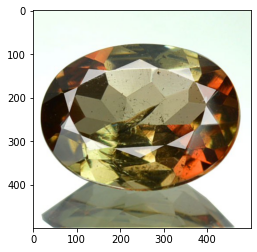

In [7]:
show_example(*dataset[200])

Label:  Garnet Red (32)
Image :  torch.Size([3, 299, 300])


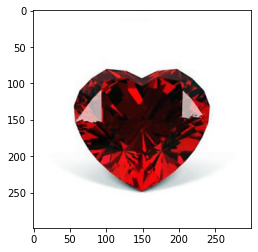

In [8]:
show_example(*dataset[1099])

In [9]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
tfms = tt.Compose([tt.CenterCrop(128), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])


In [10]:
train_ds = ImageFolder(data_dir + '/train', transform = tfms)
valid_ds = ImageFolder(data_dir + '/test', transform = tfms)

## Images after transforming

All the images are converted into tensors of size 3 x 128 x 128

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Alexandrite (0)
Image :  torch.Size([3, 128, 128])


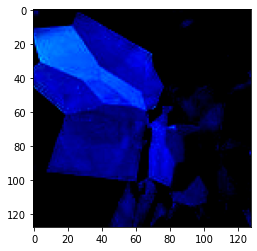

In [11]:
show_example(*train_ds[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Ametrine (5)
Image :  torch.Size([3, 128, 128])


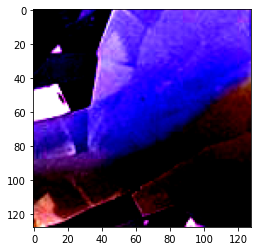

In [12]:
show_example(*valid_ds[22])

In [13]:
batch_size = 128

In [14]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

In [15]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


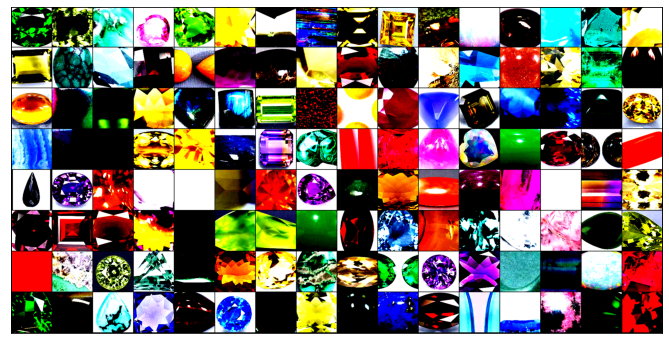

In [16]:
show_batch(train_dl)

# Using a GPU 

In [17]:
torch.cuda.is_available()

True

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Defining the model (Residual Neural Network)

In [21]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [22]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [23]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Training the Model

In [24]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
torch.cuda.empty_cache()

In [26]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.005859375, 'val_loss': 4.46751594543457}]

In [27]:
history = fit(10, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 3.8863, val_loss: 3.0637, val_acc: 0.1982
Epoch [1], train_loss: 2.4538, val_loss: 2.1302, val_acc: 0.3519
Epoch [2], train_loss: 2.0411, val_loss: 1.6859, val_acc: 0.4714
Epoch [3], train_loss: 1.9091, val_loss: 1.7108, val_acc: 0.4672
Epoch [4], train_loss: 1.7172, val_loss: 1.6637, val_acc: 0.4828
Epoch [5], train_loss: 1.7212, val_loss: 1.4925, val_acc: 0.5249
Epoch [6], train_loss: 1.5974, val_loss: 1.4547, val_acc: 0.5498
Epoch [7], train_loss: 1.4619, val_loss: 1.5201, val_acc: 0.5289
Epoch [8], train_loss: 1.3813, val_loss: 1.4487, val_acc: 0.5620
Epoch [9], train_loss: 1.3501, val_loss: 1.3353, val_acc: 0.5810


In [31]:
history = fit(10, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.0727, val_loss: 1.1498, val_acc: 0.6349
Epoch [1], train_loss: 1.0334, val_loss: 1.1063, val_acc: 0.6556
Epoch [2], train_loss: 0.9488, val_loss: 1.0877, val_acc: 0.6524
Epoch [3], train_loss: 0.9274, val_loss: 1.0958, val_acc: 0.6614
Epoch [4], train_loss: 0.8882, val_loss: 1.1076, val_acc: 0.6583
Epoch [5], train_loss: 0.8667, val_loss: 1.0882, val_acc: 0.6610
Epoch [6], train_loss: 0.8886, val_loss: 1.0808, val_acc: 0.6625
Epoch [7], train_loss: 0.8062, val_loss: 1.0951, val_acc: 0.6411
Epoch [8], train_loss: 0.8016, val_loss: 1.0541, val_acc: 0.6645
Epoch [9], train_loss: 0.7629, val_loss: 1.0516, val_acc: 0.6431


In [34]:
history = fit(10, 0.00001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.7925, val_loss: 1.0324, val_acc: 0.6723
Epoch [1], train_loss: 0.7006, val_loss: 1.0373, val_acc: 0.6649
Epoch [2], train_loss: 0.7086, val_loss: 1.0379, val_acc: 0.6696
Epoch [3], train_loss: 0.7265, val_loss: 1.0314, val_acc: 0.6770
Epoch [4], train_loss: 0.7118, val_loss: 1.0304, val_acc: 0.6669
Epoch [5], train_loss: 0.7514, val_loss: 1.0333, val_acc: 0.6630
Epoch [6], train_loss: 0.7216, val_loss: 1.0303, val_acc: 0.6747
Epoch [7], train_loss: 0.7065, val_loss: 1.0336, val_acc: 0.6657
Epoch [8], train_loss: 0.7377, val_loss: 1.0271, val_acc: 0.6688
Epoch [9], train_loss: 0.7140, val_loss: 1.0197, val_acc: 0.6774


### The highest accuracy achieved on validation dataset was 0.6774 or 67.74 %  whereas the lowest validation loss was 1.0197

# Plotting the graphs

In [35]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

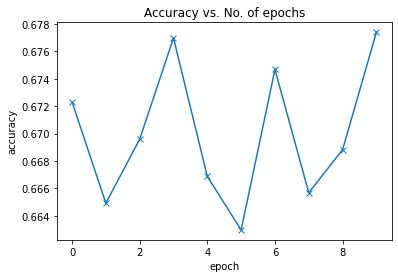

In [36]:
plot_accuracies(history)

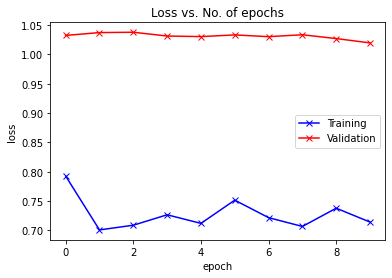

In [37]:
plot_losses(history)

# Conclusion

The final metrics were as follows :-

train_loss: 0.7140

val_loss: 1.0197

val_acc: 0.6774

Though the accuracy of the model was not as good as someone might expect. But increasing the accuracy from 0.8% to 65.72% can be considered good.